In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

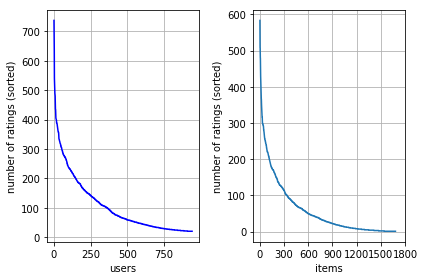

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [75]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  

    num_row = valid_ratings.shape[0]
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(0.9*num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split :]
    train = valid_ratings[index_tr]
    test = valid_ratings[index_te]
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88654
Total number of nonzero elements in test data:9298


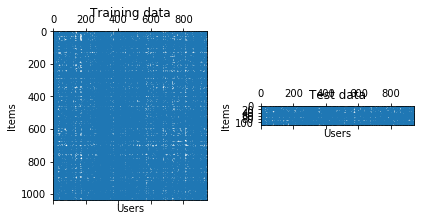

In [76]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [77]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    indices = train.nonzero()
    global_mean = np.mean(train[indices])
    indices_test = test.nonzero()
    error = 0
    A = test[indices_test]-global_mean*np.ones(test[indices_test].shape[0])
    n = len(indices_test[0])
    return (A.dot(A.T))/n
    
   
baseline_global_mean(train, test)


matrix([[ 1.27115312]])

### Use the user means as the prediction

In [78]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    indices = train.nonzero()
    users = np.unique(indices[1])
    indices_test = test.nonzero()
    mean = {}
    for i in users:
        A = np.where(indices[1]==i)
        indices_pelis_train = indices[0][A]
        mean_user = np.mean(train[indices_pelis_train,i])
        mean[i] = mean_user
        #B = np.where(indices_test[1] == i)
        #indices_pelis_test = indices[0][B]
        #for peli in indices_pelis_test:
            #mse += (test[peli,i] - mean_user)**2
            #num_ratings +=1
    mse2 = 0
    k = 0
    for i in range(len(indices_test[0])):
        A  = test[indices_test[0][i],indices_test[1][i]] - mean[indices_test[1][i]]
        mse2 += A**2
        k += 1
        
    return mse2/k

baseline_user_mean(train, test)

1.0984804842222422

### Use the item means as the prediction

In [79]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    indices = train.nonzero()
    indices_test = test.nonzero()
    item = np.unique(indices[0])
    mean_item={}
    for i in item:
        A = np.where(indices[0]==i)
        indices_pelis = indices[1][A]
        mean_item[i] = np.mean(train[i,indices_pelis])
    
    mse2 = 0
    k = 0
    for i in range(len(indices_test[0])):
        A  = test[indices_test[0][i],indices_test[1][i]] - mean_item[indices_test[0][i]]
        mse2 += A**2
        k += 1
        
    return mse2/k
    
    
baseline_item_mean(train, test)

1.6850203174973775

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [80]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    W = np.ones(train.shape[0],num_features)
    Z = np.ones(num_features, train.shape[1])
    
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    raise NotImplementedError

Compute the cost by the method of matrix factorization.


In [ ]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    raise NotImplementedError

In [ ]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
        raise NotImplementedError

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    raise NotImplementedError

matrix_factorization_SGD(train, test)   

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)